<a href="https://colab.research.google.com/github/talhaCelik61/Pytorch-Tutorial/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
#Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Colour Channels)
transform = transforms.ToTensor()

In [121]:
#Train Data
train_data = datasets.MNIST(root = '/cnn_data',train = True, download = True, transform = transform)

In [122]:
#Test Data
test_data = datasets.MNIST(root = '/cnn_data',train = False, download = True, transform = transform)

In [123]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [124]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [125]:
#Create a small batch size for images e.g. 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [126]:
#Define our CNN Model
#Describe convolutional layer and what its doing (2 convo layers)
#This is just an example, not the actual model itself
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)


In [127]:
#Grab 1 MNIST record/image
for i, (X_Train,y_train) in enumerate (train_data):
  break

In [128]:
X_Train.shape



torch.Size([1, 28, 28])

In [129]:
x = X_Train.view(1,1,28,28)

In [130]:
#Perform first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for activation function


In [131]:
x.shape

torch.Size([1, 6, 26, 26])

In [132]:
#pass through the pooling layer
x = F.max_pool2d(x,2,2) #kernel of 2 and stride of 2

In [133]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [134]:
# Do second convo layer
x = F.relu(conv2(x))

In [135]:
x.shape # 6-> 16 and 13 - 3 + 1 = 11

torch.Size([1, 16, 11, 11])

In [136]:
x = F.max_pool2d(x,2,2)

In [137]:
x.shape # We have to round down, because we cant invent data to round up

torch.Size([1, 16, 5, 5])

In [138]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #Fully connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  def forward(self,X):
    X = F.relu(conv1(X))
    X = F.max_pool2d(X,2,2) #2x2 kernel and stride of 2
    #Again
    X = F.relu(conv2(X))
    X = F.max_pool2d(X,2,2)
    #Review to flatten it out
    X = X.view(-1 , 16 * 5 * 5) #-1 so we can vary the batch size

    #Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim = 1)


In [139]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [140]:
#Loss Function Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001) # Smaller the learning rate the longer its gonna take  to train

In [142]:
import time
start_time = time.time()
#Create Variables To Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
#For Loop Of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  #Train
  for b,(X_Train,y_train) in enumerate(train_loader):
    b+=1 # Start batches at 1
    y_pred = model(X_Train) # Get predicted values from the training set. Not flattened. 2D.
    loss = criterion(y_pred,y_train)# how off are we? Compare predictions to correct ones.
    predicted = torch.max(y_pred.data, 1)[1] # Add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # How many we got correct from this specific batch. True = 1, False = 0.
    trn_corr += batch_corr # keep track as we go along in training.

    #Update Our Parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Print Out Some Results
    if b%600 == 0:
      print(f'Epoch: {i}.)  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Test
  with torch.no_grad(): # no gradient so we dont update our weights and biases with test data
    for b,(X_Test,y_test) in enumerate(test_loader):
      b+=1
      y_val = model(X_Test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr +=(predicted == y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)





current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')


Epoch: 0.)  Batch: 600  Loss: 0.014594465494155884
Epoch: 0.)  Batch: 1200  Loss: 0.06739065796136856
Epoch: 0.)  Batch: 1800  Loss: 0.23990169167518616
Epoch: 0.)  Batch: 2400  Loss: 0.34851378202438354
Epoch: 0.)  Batch: 3000  Loss: 0.015981605276465416
Epoch: 0.)  Batch: 3600  Loss: 0.008134868927299976
Epoch: 0.)  Batch: 4200  Loss: 0.04323998838663101
Epoch: 0.)  Batch: 4800  Loss: 0.06508933007717133
Epoch: 0.)  Batch: 5400  Loss: 0.059636104851961136
Epoch: 0.)  Batch: 6000  Loss: 0.041640542447566986
Epoch: 1.)  Batch: 600  Loss: 0.07271088659763336
Epoch: 1.)  Batch: 1200  Loss: 0.23401875793933868
Epoch: 1.)  Batch: 1800  Loss: 0.013102000579237938
Epoch: 1.)  Batch: 2400  Loss: 0.017073996365070343
Epoch: 1.)  Batch: 3000  Loss: 0.002404317259788513
Epoch: 1.)  Batch: 3600  Loss: 0.006708370987325907
Epoch: 1.)  Batch: 4200  Loss: 0.13871198892593384
Epoch: 1.)  Batch: 4800  Loss: 0.005557752214372158
Epoch: 1.)  Batch: 5400  Loss: 0.19386865198612213
Epoch: 1.)  Batch: 6000

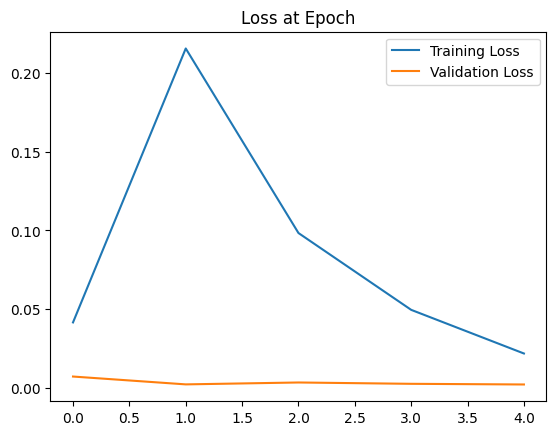

In [143]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses,label = "Training Loss")
plt.plot(test_losses,label = "Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

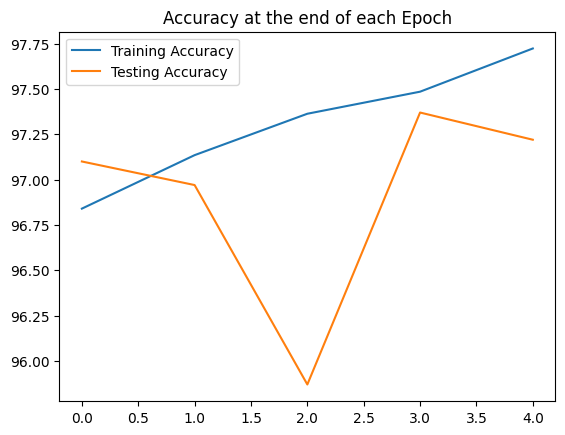

In [145]:
#graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct],label = "Training Accuracy")
plt.plot([t/100 for t in test_correct],label = "Testing Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()


In [146]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [147]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [149]:
#Test for correct
correct.item()/len(test_data)*100


97.22

In [151]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [152]:
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

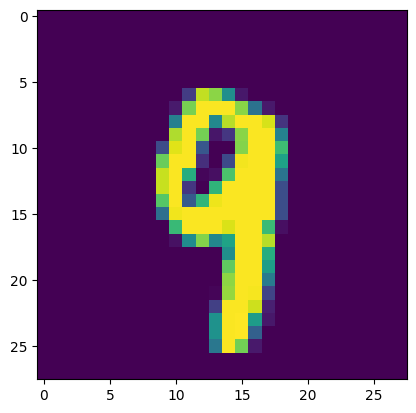

In [153]:
#Show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [154]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) # batch size of 1, 1 colour channel, 28*28 image


In [155]:
new_prediction

tensor([[-1.8220e+01, -2.0552e+01, -1.5478e+01, -1.0345e+01, -8.4984e+00,
         -1.2129e+01, -2.6979e+01, -9.9129e+00, -9.2945e+00, -3.8307e-04]])

In [157]:
new_prediction.argmax()


tensor(9)